In [5]:
!pip install -qU python-dotenv

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from PIL import Image

In [2]:
# Load the OWL-ViT model
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

In [14]:
# Load and preprocess the image
image_path = "image.jpg"  # Change this to your image path
image = Image.open(image_path).convert("RGB")

In [37]:
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

client = OpenAI()



def get_object_description(user_queries):
    """
    Uses an LLM to refine each list of object queries.
    user_queries is a list of lists: [["query1"], ["query2"], ...]
    Returns a refined list of lists: [["refined1"], ["refined2"], ...]
    """
    refined_queries = []

    for query_list in user_queries:
        if not query_list:
            continue  # Skip empty lists

        user_query = query_list  # Extract the string from list
        print(user_query)
        response = client.chat.completions.create(
            model="gpt-4o",
            temperature = 0.85,
            messages=[
                {"role": "system", "content": "Refine object descriptions for detection. Provide concise short object names."},
                {"role": "user", "content": f"Refine this object query: '{user_query}' and give a better description for the user query."},
                {"role": "user", "content": f"Use a descriptive short text only in the refined query and do not generate text like \"Object:\" ."}
            ]
        )

        # Parse LLM response
        refined_text = response.choices[0].message.content.replace("\"","").strip()
        refined_queries.append(refined_text)  # Keep the list of lists format

    return [refined_queries]

# User's natural language queries as a list of lists
user_queries = ["Cell Phone", "Wrist Watch", "Find the keys", ""]
# Define the text prompt for object detection
text_queries = get_object_description(user_queries)
print(f"Refined Queries for Object Detection: {text_queries}")


Cell Phone
Wrist Watch
Find the keys
Refined Queries for Object Detection: [['Smartphone', 'Watch', 'Locate keys']]


In [38]:
# Preprocess the inputs
inputs = processor(text=text_queries, images=image, return_tensors="pt", padding=True, truncation=True)

# Perform object detection
with torch.no_grad():
    outputs = model(**inputs)

In [39]:
# Extract results
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.07)
results

[{'scores': tensor([0.0948, 0.0936, 0.0766, 0.2037]),
  'labels': tensor([0, 1, 1, 2]),
  'boxes': tensor([[292.1159, 251.0964, 468.2943, 478.4125],
          [116.8530, 474.1841, 193.0560, 545.9979],
          [437.5489, 477.5869, 520.3254, 562.5339],
          [197.5794, 483.0083, 312.4503, 583.0664]])}]

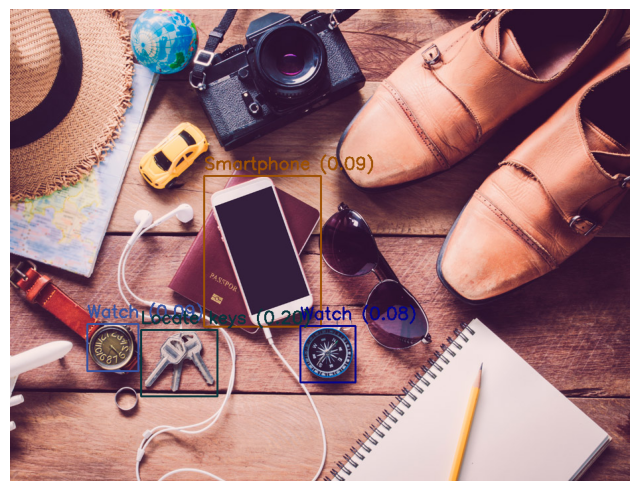

In [40]:
# Get bounding boxes and labels
boxes = results[0]["boxes"]
scores = results[0]["scores"]
labels = results[0]["labels"]

# Draw the bounding boxes on the image
image_np = np.array(image)
k = results[0].get('labels').size()[0]
intensities = np.random.randint(0, 200, (k,3))
for box, score, label, intensity in zip(boxes, scores, labels, intensities):
    box = [int(b) for b in box.tolist()]
    text = f"{text_queries[0][label]} ({score:.2f})"

    # Draw bounding box
    b,g,r = intensity
    color = (int(b),int(g),int(r))
    cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), color, 2)

    # Add label text
    cv2.putText(image_np, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.85, color, 2)

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(image_np)
plt.axis("off")
plt.show()